In [3]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset



%matplotlib widget
%load_ext autoreload
%autoreload 2
from stressgait_analysis.gait_helper_functions import (compute_HS)
import numpy as np

In [27]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait = {
    "omc": omc_color,
    "control": controls_color
}

In [28]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

In [29]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)

In [30]:
kinematics = dataset.kinematics.droplevel(level="bout")
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q.head()

hip_flexion  knee_flexion  \
participant condition speed percentage_of_stride                              
VP_01       omc       fast  0                       16.672305     -1.643508   
                            1                       16.742015     -1.106875   
                            2                       16.800376     -0.381644   
                            3                       16.813459      0.991988   
                            4                       16.754319      2.397110   

                                                  elbow_angle  shoulder_angle  \
participant condition speed percentage_of_stride                                
VP_01       omc       fast  0                      173.363706      167.973590   
                            1                      173.726198      167.528950   
                            2                      174.109902      167.115063   
                            3                      174.568835      166.810044   
                            4                      175.053780      166.570782   

                                                  arm_swing  
participant condition speed percentage_of_stride             
VP_01       omc       fast  0                    -41.723325  
                            1                    -43.326227  
                            2                    -44.823183  
                            3                    -45.944825  
                            4                    -46.840332

split into omc / control as well as fast / slow

In [31]:
omc_kinematics_slow = cycle_averaged_q.xs(("omc", "slow"), level=("condition", "speed"))
omc_kinematics_fast = cycle_averaged_q.xs(("omc", "fast"), level=("condition", "speed"))

control_kinematics_slow = cycle_averaged_q.xs(("control", "slow"), level=("condition", "speed"))
control_kinematics_fast = cycle_averaged_q.xs(("control", "fast"), level=("condition", "speed"))

for spm, we need data in the format J x Q, where J are the participants per group and Q are the nodes

In [32]:
omc_slow_hip = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_slow_knee = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

control_slow_hip = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_slow_knee = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

omc_fast_hip = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_fast_knee = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")

control_fast_hip = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_fast_knee = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")


In [81]:
def plot_result(YA, YB, ti, ylabel=None):
### plot mean and SD:
    fig = plt.figure( figsize=(8, 3.5) )
    ax     = plt.axes( (0.1, 0.15, 0.35, 0.8) )
    spm1d.plot.plot_mean_sd(YA, linecolor=stressgait["omc"],label="omc", facecolor=stressgait["omc"], ax=ax)
    spm1d.plot.plot_mean_sd(YB,  linecolor=stressgait["control"], label= "control", facecolor=stressgait["control"], ax=ax)
    ax.axhline(y=0, color='k', linestyle=':')
    ax.set_xlabel('% of stride')
    ax.set_ylabel(ylabel)
    plt.legend()
    ### plot SPM results:
    ax= plt.axes((0.55,0.15,0.35,0.8))

    ti.plot(facecolor="red")

    ax.set_ylabel( "SPM{t}",fontsize=12, fontweight="normal")  # Match your other plots

   # ti.plot_threshold_label(fontsize=8)
    alpha = 0.0125
    tstar = ti.zstar  # or use the threshold value directly

# Optional: plot the threshold line manually if not already present
    plt.axhline(y=tstar, linestyle='--', color='k')

# Add your custom label
    plt.text(
    x=60,       # e.g. 5 or plt.xlim()[0] + some_offset
    y=tstar + 0.1,           # position slightly above the line
    s=f"α = {alpha:.4f}, t* = {tstar:.3f}",
    fontsize=10,
    color='red',
    ha='center'
)
    ti.plot_p_values(size=10, offsets=[(30,0.3)])
    ax.set_xlabel('')
    return fig

## SPM for the hip

### slow

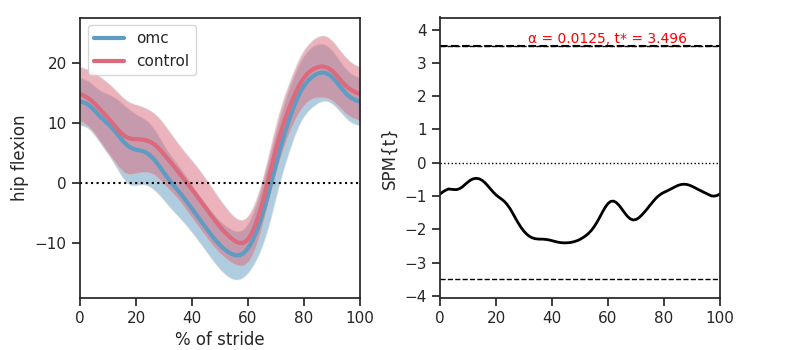

In [74]:
t = spm1d.stats.ttest2(np.array(omc_slow_hip), np.array(control_slow_hip))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_slow_hip, control_slow_hip, ti, "hip flexion")
plt.show()

### fast

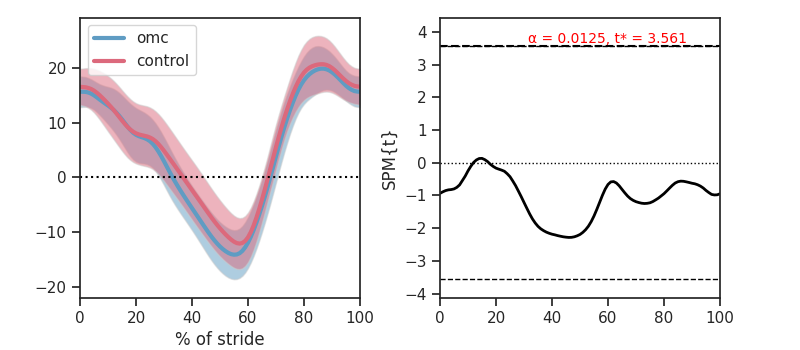

In [75]:
t = spm1d.stats.ttest2(np.array(omc_fast_hip), np.array(control_fast_hip))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_fast_hip, control_fast_hip, ti)

## knee

### slow

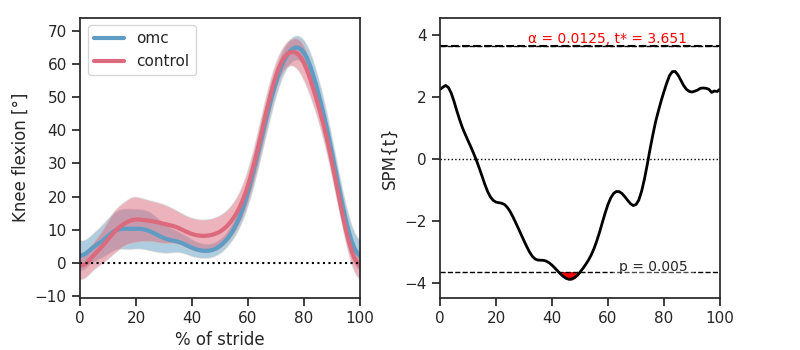

In [82]:
t = spm1d.stats.ttest2(np.array(omc_slow_knee), np.array(control_slow_knee))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_slow_knee, control_slow_knee, ti, "Knee flexion [°]")
plt.savefig("../../exports/spm_knee_slow.pdf")

### fast

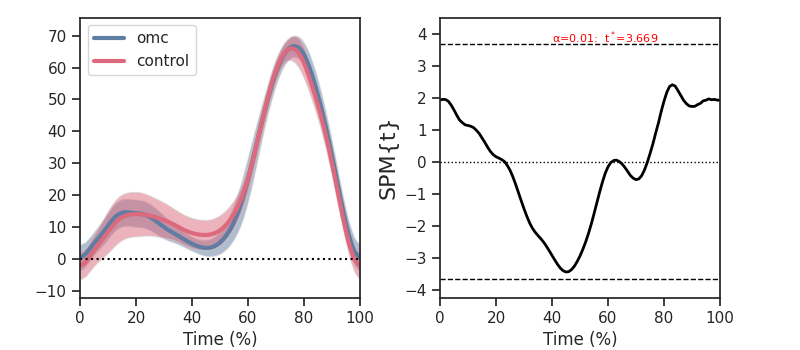

In [15]:
t = spm1d.stats.ttest2(np.array(omc_fast_knee), np.array(control_fast_knee))
ti = t.inference(alpha=0.05/4)
figure = plot_result(omc_fast_knee, control_fast_knee, ti)

In [22]:
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q.head()
c = cycle_averaged_q.reset_index()

In [23]:
responder_list = ["VP_02", "VP_05", "VP_06", "VP_15", "VP_16", "VP_17", "VP_24", "VP_35", "VP_36", "VP_43", "VP_45", "VP47"]
cycle_averaged_q["responder"] = [1 if r[1].participant in responder_list else 0 for r in c.iterrows()]
cycle_averaged_q.set_index("responder", append=True, inplace=True)

In [24]:
cycle_averaged_q

hip_flexion  \
participant condition speed percentage_of_stride responder                
VP_01       omc       fast  0                    0            16.672305   
                            1                    0            16.742015   
                            2                    0            16.800376   
                            3                    0            16.813459   
                            4                    0            16.754319   
...                                                                 ...   
VP_47       omc       slow  96                   0            19.038657   
                            97                   0            18.706096   
                            98                   0            18.331759   
                            99                   0            17.919661   
                            100                  0            17.486822   

                                                            knee_flexion  \
participant condition speed percentage_of_stride responder                 
VP_01       omc       fast  0                    0             -1.643508   
                            1                    0             -1.106875   
                            2                    0             -0.381644   
                            3                    0              0.991988   
                            4                    0              2.397110   
...                                                                  ...   
VP_47       omc       slow  96                   0             18.334700   
                            97                   0             15.990487   
                            98                   0             14.138599   
                            99                   0             12.764022   
                            100                  0             11.682882   

                                                            elbow_flexion_angles  \
participant condition speed percentage_of_stride responder                         
VP_01       omc       fast  0                    0                      6.636294   
                            1                    0                      6.273802   
                            2                    0                      5.890098   
                            3                    0                      5.431165   
                            4                    0                      4.946220   
...                                                                          ...   
VP_47       omc       slow  96                   0                     24.638156   
                            97                   0                     24.357371   
                            98                   0                     24.124597   
                            99                   0                     23.922619   
                            100                  0                     23.739049   

                                                            arm_swing_angles  
participant condition speed percentage_of_stride responder                    
VP_01       omc       fast  0                    0                 12.026410  
                            1                    0                 12.471050  
                            2                    0                 12.884937  
                            3                    0                 13.189956  
                            4                    0                 13.429218  
...                                                                      ...  
VP_47       omc       slow  96                   0                  5.154072  
                            97                   0                  5.462810  
                            98                   0                  5.709183  
                            99                   0                  5.898325  
                            100                  0    

In [25]:
kin_responder = cycle_averaged_q.xs((1, "slow"), level=("responder", "speed"))
kin_non_responder= cycle_averaged_q.xs((0, "slow"), level=("responder", "speed"))